In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from scipy.stats import linregress
from sklearn.model_selection import KFold
from pytorch_stats_joint_model_multidim import * 
import glob, h5py
import pickle
from tqdm import tqdm
from sklearn.metrics import r2_score 
from scipy.optimize import least_squares


%matplotlib notebook

import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False, 'axes.labelcolor': '0', 'text.color':'0', 'xtick.color':'0', 'ytick.color':'0'}),

SMALL_SIZE = 12
MEDIUM_SIZE = 21
BIGGER_SIZE = 21

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
data_file = sorted(glob.glob('../data_spikes/*.mat'))
f = h5py.File(data_file[1],'r')
ref_spikes = f['spikes']
ref_stim = f['stim']
V1_spks = np.array(f[ref_spikes[0,0]]) #3200 trials x 1280 ms x n1
V2_spks = np.array(f[ref_spikes[1,0]]) #3200 trials x 1280 ms x n2
stim = np.array(f.get('/stim')) # 1x3200 trials

n_trial, T, n1 = V1_spks.shape
junk, junk, n2 = V2_spks.shape
n_stim = int(np.max(stim))
print(n1, n2)

#bin the data
bin_width = 100
n_bin = int(T/bin_width)
V1_spks_binned = np.reshape(V1_spks[:, :n_bin*bin_width, :], (n_trial, bin_width, n_bin, n1), order='F')
V1_spks_binned = np.sum(V1_spks_binned, 1)

V2_spks_binned = np.reshape(V2_spks[:, :n_bin*bin_width, :], (n_trial, bin_width, n_bin, n2), order='F')
V2_spks_binned = np.sum(V2_spks_binned, 1)

stim_order = np.argsort(stim[0,:])
V1_spks_binned = V1_spks_binned[stim_order,:,:]
V1_tmp = np.mean(V1_spks_binned[:400, :, :],0)
neuron_order = np.argsort(np.max(V1_tmp,0)) #order neuron based on their peak responses during orientaton 0

V2_spks_binned = V2_spks_binned[stim_order,:,:]
V2_tmp = np.mean(V2_spks_binned[:400, :, :],0)
neuron_order2 = np.argsort(np.max(V2_tmp,0))


V1_tuning = np.zeros((n1,n_stim))
V2_tuning = np.zeros((n2,n_stim))
for stim_i in range(n_stim):
    V1_tuning[:, stim_i] = np.mean(V1_spks_binned[400*stim_i: 400*(stim_i+1),int(100/bin_width):,:],(0,1)) # (n1,)
    V2_tuning[:, stim_i] = np.mean(V2_spks_binned[400*stim_i: 400*(stim_i+1),int(100/bin_width):,:],(0,1)) # (n2,)


V1_f = np.sum(V1_spks_binned[:,int(100/bin_width):,:],1).T
V2_f = np.sum(V2_spks_binned[:,int(100/bin_width):,:],1).T


109 30


In [4]:
def soft_cluster(f):
    # cluster based on score of maximum absolute value
    cluster_ids = np.argmax(np.abs(f), axis=1)
    scores = f[range(f.shape[0]), cluster_ids]

    # resort within each cluster
    perm = []
    for cluster in np.unique(cluster_ids):
        idx = np.where(cluster_ids == cluster)[0]
        perm += list(idx[np.argsort(scores[idx])][::-1])
    return cluster_ids, perm

In [5]:
#exclude silent neurons
if (V1_tuning==0).any():
    id_silent = np.unique(np.where(V1_tuning==0)[0])
    print(id_silent)
    V1_f = np.delete(V1_f, id_silent, axis=0)
    V1_tuning = np.delete(V1_tuning, id_silent, axis=0)
    n1 -= id_silent.shape[0]
    print(V1_f.shape)

if (V2_tuning==0).any():
    id_silent = np.unique(np.where(V2_tuning==0)[0])
    print(id_silent)
    V2_f = np.delete(V2_f, id_silent, axis=0)
    V2_tuning = np.delete(V2_tuning, id_silent, axis=0)
    n2 -= id_silent.shape[0]
    print(V2_f.shape)

pref_ori_V1, tuning_order_V1 = soft_cluster(V1_tuning)
pref_ori_V2, tuning_order_V2 = soft_cluster(V2_tuning)

n1,n2

[15]
(29, 3200)


(109, 29)

In [6]:
def calculate_OTI_direct(V1_tuning):
    
    tuning = V1_tuning
    max_tuning = np.max(tuning,1)
    min_tuning = np.min(tuning,1)

    OTI = (max_tuning-min_tuning)/(max_tuning+min_tuning)
    return OTI

OTI_V1_direct = calculate_OTI_direct(V1_tuning)
OTI_V2_direct = calculate_OTI_direct(V2_tuning)

thr = 0.35
print(len(np.where(OTI_V1_direct>thr)[0]))
print(len(np.where(OTI_V2_direct>thr)[0]))

n1 = np.sum(OTI_V1_direct>thr)
n2 = np.sum(OTI_V2_direct>thr)

V1_f_new = V1_f[OTI_V1_direct>thr, :]
V2_f_new = V2_f[OTI_V2_direct>thr, :]

V1_f= V1_f_new
V2_f= V2_f_new

V1_tuning = V1_tuning[OTI_V1_direct>0.35,:]
V2_tuning = V2_tuning[OTI_V2_direct>0.35,:]

pref_ori_V1, tuning_order_V1 = soft_cluster(V1_tuning)
pref_ori_V2, tuning_order_V2 = soft_cluster(V2_tuning)


n_trial =400
V1_f_ = V1_f.reshape((n1, n_trial, n_stim), order='F')
V2_f_ = V2_f.reshape((n2, n_trial, n_stim), order='F')
n_trial_train = 320
n_trial_test = 80

63
24


In [7]:
n = n1+n2

## Fit joint statistical models

In [ ]:
kf = KFold(n_splits=5,shuffle=True)
split=0

aff_joint_model_all = [] # joint affine models
mul_joint_model_all = [] # joint multiplicative models
add_varp_joint_model_all = [] # joint additive models

gen_joint_model_all = [] # joint generalized models
add_joint_model_all = [] # This is NOT the joint additive model used in Xia et al 2023, this joint additive model assumes stimulus-independent area-private variability

# index of trials in 5-fold cross-validation
train_ind_all = []
test_ind_all = []


for train_ind, test_ind in kf.split(np.arange(n_trial)):
    split += 1
    
    train_ind_all.append(train_ind)
    test_ind_all.append(test_ind)
    
    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')
    
    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')
    
    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')

    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')
    
    x_train = np.concatenate((x1, x2), axis=0)
    x_test = np.concatenate((x_test1, x_test2), axis=0)
    
    for n_compo in range(1,6):

        gen_joint_model = generalized_joint_model(x_train, n1, n2, n_stim, n_trial_train, n_compo, x_test, n_trial_test)
        add_joint_model = additive_joint_model(x_train, n1, n2, n_stim, n_trial_train, n_compo, x_test, n_trial_test)

        gen_joint_model_all.append(gen_joint_model)
        add_joint_model_all.append(add_joint_model)
        
        h_p_init = add_joint_model.F_p.copy()
        psi1_p_init = gen_joint_model.psi_p[:n1,:n1,:].copy()
        psi2_p_init = gen_joint_model.psi_p[n1:,n1:,:].copy()

        add_varp_joint_model = additive_varp_joint_model(x_train, n1, n2, n_stim, n_trial_train, n_compo, h_p_init, psi1_p_init, psi2_p_init)
        junk = add_varp_joint_model.train(1e-2, x_train, n_trial_train)
        
        add_varp_joint_model_all.append(add_varp_joint_model)
        
        alpha_p_init = np.zeros((n, n_compo))
        psi1_p_init = gen_joint_model.psi_p[:n1,:n1,:].copy()
        psi2_p_init = gen_joint_model.psi_p[n1:,n1:,:].copy()
        beta_p_init = add_varp_joint_model.h_p.detach().numpy().copy()

        aff_joint_model = affine_joint_model(x_train, n1, n2, n_stim, n_trial_train, n_compo, alpha_p_init, beta_p_init,  psi1_p_init, psi2_p_init)
        junk = aff_joint_model.train(1e-2, x_train, n_trial_train)
        
        aff_joint_model_all.append(aff_joint_model)
        
        
        alpha_p_init = aff_joint_model.alpha_p.detach().numpy().copy()
        psi1_p_init = gen_joint_model.psi_p[:n1,:n1,:].copy()
        psi2_p_init = gen_joint_model.psi_p[n1:,n1:,:].copy()
        mul_joint_model = multiplicative_joint_model(x_train, n1, n2, n_stim, n_trial_train, n_compo, alpha_p_init,  psi1_p_init, psi2_p_init)
        junk = mul_joint_model.train(1e-2, x_train, n_trial_train)
        
        mul_joint_model_all.append(mul_joint_model)
    



In [ ]:
# with open('write_your_own_path', 'wb') as file:
#     pickle.dump([train_ind_all, test_ind_all,
#                  aff_joint_model_all, 
#                  mul_joint_model_all, 
#                  add_varp_joint_model_all,
#                  gen_joint_model_all,
#                  add_joint_model_all], file)

## Load trained joint statistical models

In [8]:
with open('./stats_model_fitting_res/joint_stats_model_res/dataset1_joint_stats_models_5_fold_cv.pkl', 'rb') as fp:
                [train_ind_all, test_ind_all,
                 aff_joint_model_all, 
                 mul_joint_model_all, 
                 add_varp_joint_model_all,
                 gen_joint_model_all,
                 add_joint_model_all] = pickle.load(fp)

## Plot fitting performance (log-likelihood) of joint statistical models

In [9]:
def plot_LL(x, x_test, add_model, add_varp_model, mul_model, aff_model, gen_model):
    ll_add = -add_model.NLL
    ll_add_test = -add_model.NLL_test

    ll_add_varp = -add_varp_model.loss_nll(x, n_trial_train)
    ll_add_varp_test = -add_varp_model.loss_nll(x_test, n_trial_test)

    ll_mul = -mul_model.loss_nll(x, n_trial_train)
    ll_mul_test = -mul_model.loss_nll(x_test, n_trial_test)
    
    ll_aff = -aff_model.loss_nll(x, n_trial_train)
    ll_aff_test = -aff_model.loss_nll(x_test, n_trial_test)
    
    ll_gen = -gen_model.NLL
    ll_gen_test = -gen_model.NLL_test

    ll_train = [ll_add, ll_add_varp.detach().numpy(), ll_mul.detach().numpy(), ll_aff.detach().numpy(), ll_gen]
    ll_test = [ll_add_test, ll_add_varp_test.detach().numpy(), ll_mul_test.detach().numpy(), ll_aff_test.detach().numpy(),ll_gen_test]

    return ll_train, ll_test

In [10]:
n_compo_len = 5
n_fold = 5

ll_train1_all = np.zeros((5, n_compo_len, n_fold))
ll_test1_all = np.zeros((5, n_compo_len, n_fold))

colors = plt.cm.inferno(np.linspace(0,0.9,n_compo_len))

# plot for different component
for i in range(n_compo_len):
    for j in range(n_fold):
        
        train_ind = train_ind_all[j]
        test_ind = test_ind_all[j]

        V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
        V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

        V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
        V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

        x1 = V1_f_train.reshape(n1, -1, order='F')
        x_test1 = V1_f_test.reshape(n1, -1, order='F')

        x2 = V2_f_train.reshape(n2, -1, order='F')
        x_test2 = V2_f_test.reshape(n2, -1, order='F')

        x_train = np.concatenate((x1, x2), axis=0)
        x_test = np.concatenate((x_test1, x_test2), axis=0)
        
        
        add_model_V1 = add_joint_model_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_joint_model_all[i+j*n_compo_len]
        mul_model_V1 = mul_joint_model_all[i+j*n_compo_len]
        aff_model_V1 = aff_joint_model_all[i+j*n_compo_len]
        gen_model_V1 = gen_joint_model_all[i+j*n_compo_len]

        ll_train1, ll_test1 = plot_LL(x_train, x_test, add_model_V1, add_varp_model_V1, mul_model_V1, aff_model_V1, gen_model_V1)

        ll_train1_all[:,i,j] = ll_train1
        ll_test1_all[:,i,j] = ll_test1
        

<IPython.core.display.Javascript object>


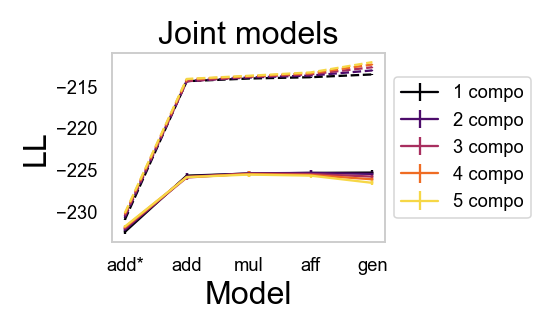

In [11]:
fig,ax = plt.subplots(1,1, figsize=(5,3))
for i in range(n_compo_len):
    ax.errorbar(np.arange(5), np.mean(ll_train1_all[:,i,:],1),np.std(ll_train1_all[:,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax.errorbar(np.arange(5), np.mean(ll_test1_all[:,i,:],1),np.std(ll_test1_all[:,i,:],1)/np.sqrt(n_fold), color=colors[i], label='%d compo'%(i+1))
    

ax.set_title('Joint models')

plt.xticks([0,1,2,3,4], ['add*', 'add', 'mul', 'aff', 'gen'])
plt.ylabel('LL')
plt.xlabel('Model')
plt.legend()


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

<IPython.core.display.Javascript object>


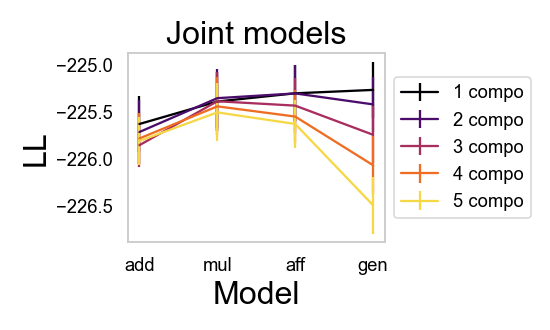

In [12]:
fig,ax = plt.subplots(1,1, figsize=(5,3))
for i in range(n_compo_len):
    #ax.errorbar(np.arange(4), np.mean(ll_train1_all[1:,i,:],1),np.std(ll_train1_all[1:,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax.errorbar(np.arange(4), np.mean(ll_test1_all[1:,i,:],1),np.std(ll_test1_all[1:,i,:],1)/np.sqrt(n_fold), color=colors[i], label='%d compo'%(i+1))
    

ax.set_title('Joint models')

plt.xticks([0,1,2,3], ['add', 'mul', 'aff', 'gen'])
plt.ylabel('LL', fontsize=MEDIUM_SIZE)
plt.xlabel('Model', fontsize=MEDIUM_SIZE)
plt.legend()


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
#plt.savefig('2023_fig/utah_array_joint_stats_model/dataset_1_only_test_LL.pdf', transparent=True)

## Plot fitting performances ($R^2$ of noise covariance) of joint statistical models

In [14]:
def calculate_nc(V1_f,n1, n_trial, n_stim=8):
    #calculate noise covariance 
    V1_spks_res = np.zeros((n_trial*n_stim, n1)) 
    for stim_i in range(n_stim):
        trial_avg = np.mean(V1_f[:, n_trial*stim_i: n_trial*(stim_i+1)],1)
        V1_spks_res[n_trial*stim_i: n_trial*(stim_i+1),:] = (V1_f[:,n_trial*stim_i: n_trial*(stim_i+1)] - trial_avg[:,np.newaxis]).T

    ncov_V1 = np.zeros((n1, n1, n_stim)) 
    
    ## plot nc with axis centered around neurons' whose pref ori match with the input
    for stim_i0 in range(n_stim):
        ncov_V1[:,:, stim_i0] = np.cov(V1_spks_res[n_trial*stim_i0: n_trial*(stim_i0 + 1), :].T)

    return ncov_V1

def calculate_r2_nc_btw(ncov_V12, ncov_V12_add, n1, n2, n_stim=8):
    #ncov from data
    x1 = np.zeros((int(n1*n2), n_stim))
    
    #ncov from model
    x2 = np.zeros((int(n1*n2), n_stim))
    
    for stim_i in range(n_stim):
        tmp = ncov_V12[:,:, stim_i]
        x1[:, stim_i] = tmp.flatten()
        
        tmp = ncov_V12_add[:,:, stim_i]
        x2[:, stim_i] = tmp.flatten()
        
    r2 = r2_score(x1, x2)
    return r2

In [15]:
def calculate_ncov_from_phi(phi):
    #phi is n x n_compo x n_stim 
    ncov = np.einsum('ijk, ljk->ilk', phi, phi)
    return ncov

def calculate_phi_from_model(add_model, add_varp_model, mul_model, aff_model,gen_model,  n_stim=8):
    phi_add = np.tile(add_model.F_p[:,:, None], (1,1,n_stim))
    
    phi_add_varp = np.tile(add_varp_model.h_p[:,:,None].detach().numpy(), (1,1,n_stim))
    
    phi_mul_tmp = mul_model.alpha_p[:,:,None]*mul_model.d_p[:,None,:]
    phi_mul = phi_mul_tmp.detach().numpy()
    
    phi_aff_tmp = aff_model.alpha_p[:,:,None]*aff_model.d_p[:,None,:]+aff_model.beta_p[:,:,None]
    phi_aff = phi_aff_tmp.detach().numpy()
    
    phi_gen = gen_model.F_p
    
    return phi_add, phi_add_varp, phi_mul, phi_aff, phi_gen

In [16]:
r2_nc_V12_all = np.zeros((5, n_compo_len, n_fold))

for j in range(n_fold):

    train_ind = train_ind_all[j]
    test_ind = test_ind_all[j]

    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')

    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')

    x_train = np.concatenate((x1, x2), axis=0)
    x_test = np.concatenate((x_test1, x_test2), axis=0)
    
    ncov_V12= calculate_nc(x_test, n, n_trial_test, n_stim)

    
    for i in range(n_compo_len):
        add_model_V1 = add_joint_model_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_joint_model_all[i+j*n_compo_len]
        mul_model_V1 = mul_joint_model_all[i+j*n_compo_len]
        aff_model_V1 = aff_joint_model_all[i+j*n_compo_len]
        gen_model_V1 = gen_joint_model_all[i+j*n_compo_len]
        
        phi_V12 = calculate_phi_from_model(add_model_V1, add_varp_model_V1, mul_model_V1, aff_model_V1, gen_model_V1, n_stim=8)

        ncov_from_phi_V1 = [np.zeros((n,n,n_stim))]*5

        
        for model_i, phi in enumerate(phi_V12):
            ncov_from_phi_V1[model_i] = calculate_ncov_from_phi(phi)
            

        #plot r2 for ncov_V1
        r2_nc_V12 = []      
        
        for ncov_V1_model in ncov_from_phi_V1:

            r2_model = calculate_r2_nc_btw(ncov_V12[:n1,n1:,:], ncov_V1_model[:n1,n1:,:], n1,n2, n_stim)
            r2_nc_V12.append(r2_model)

            
        r2_nc_V12_all[:,i,j] = r2_nc_V12
      

<IPython.core.display.Javascript object>


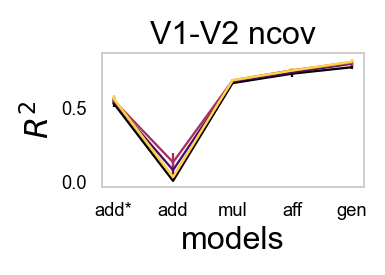

In [17]:
fig, ax = plt.subplots(1,1,figsize=(3.5,2.5))

for i in range(n_compo_len):
    ax.errorbar(range(5), np.mean(r2_nc_V12_all[:,i,:],1),np.std(r2_nc_V12_all[:,i,:],1)/np.sqrt(n_fold) , c = colors[i])

model_label=['add*', 'add','mul', 'aff','gen']

plt.xticks(range(len(model_label)), model_label)
plt.ylabel('$R^2$')
plt.xlabel('models')
plt.title('V1-V2 ncov')


plt.tight_layout()

<IPython.core.display.Javascript object>


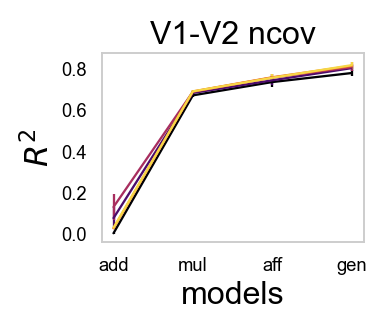

In [18]:
fig, ax = plt.subplots(1,1,figsize=(3.5,3))

for i in range(n_compo_len):
    ax.errorbar(range(4), np.mean(r2_nc_V12_all[1:,i,:],1),np.std(r2_nc_V12_all[1:,i,:],1)/np.sqrt(n_fold) , c = colors[i])

model_label=['add','mul', 'aff','gen']

plt.xticks(range(len(model_label)), model_label)
plt.ylabel('$R^2$', fontsize=MEDIUM_SIZE)
plt.xlabel('models', fontsize=MEDIUM_SIZE)
plt.title('V1-V2 ncov')
#plt.yticks(np.arange(0,0.9,0.4))

plt.tight_layout()
#plt.savefig('2023_fig/utah_array_joint_stats_model/dataset4_R2_full_axis.pdf', transparent=True)

<IPython.core.display.Javascript object>


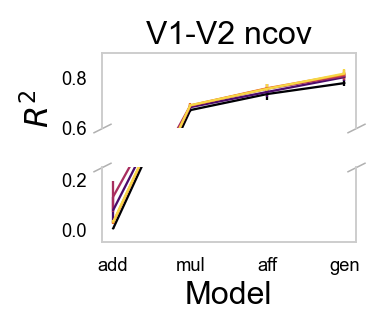

In [21]:
fig,(ax1,ax2) = plt.subplots(2,1, sharex = True, figsize=(3.5,3))#, height_ratios=(1,1))
for i in range(n_compo_len):
    ax1.errorbar(range(4), np.mean(r2_nc_V12_all[1:,i,:],1),np.std(r2_nc_V12_all[1:,i,:],1)/np.sqrt(n_fold) , c = colors[i])
    ax2.errorbar(range(4), np.mean(r2_nc_V12_all[1:,i,:],1),np.std(r2_nc_V12_all[1:,i,:],1)/np.sqrt(n_fold) , c = colors[i])

ax2.set_ylim(-0.05, 0.25)
ax1.set_ylim(0.6, 0.9)

#ax1.set_yticks([-199,-196])
#ax2.set_yticks([-209,-206])

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)    
ax1.set_title('V1-V2 ncov')

ax2.set_xticks([0,1,2,3], [ 'add', 'mul', 'aff', 'gen'])
ax1.set_ylabel('$R^2$', loc='bottom', fontsize=MEDIUM_SIZE)
ax2.set_xlabel('Model', fontsize=MEDIUM_SIZE)

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none",color='#b0b0b0', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.tight_layout()
#plt.savefig('2023_fig/utah_array_joint_stats_model/dataset1_R2.pdf', transparent=True)

## Visualize amplitude of shared variability between V1 and V2 from the fitted joint statistical models

In [40]:
## visualize phi and d
def plot_shared_noise_coef(d, phi_V1, tuning_order):
    n = len(tuning_order)
    
    plt.figure(figsize=(9,3))
    ax1 = plt.subplot(151)
    plt.imshow(d[tuning_order,:], aspect='auto', cmap='viridis')#, vmin=0, vmax=np.max(gen_model.d_p))
    plt.title('Trial-avg',fontsize=MEDIUM_SIZE)
    plt.ylabel('Neuron',fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.yticks([0, n1-1, n-1],[1, n1, n])
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    ax1.tick_params(bottom=True)
    cbar = plt.colorbar()
    bbox = cbar.ax.get_position()
    plt.text(bbox.x0 + bbox.width / 2, 1.02, '(Hz)', transform=cbar.ax.transAxes, va='bottom', ha='left')
    
    comp_ind=0

    F_p = phi_V1[4][:,comp_ind,:]
    for stim_i in range(n_stim):
    # unify the sign of F_p across stimuli. 
        if stim_i ==0:
            ref_F = F_p[:,0]
        else:
            sign = (np.sum(ref_F * F_p[:, stim_i]) > np.sum(-ref_F * F_p[:, stim_i]))
            if not sign:
                F_p[:, stim_i] *= -1

    if np.sum(ref_F)<0:
        F_p = F_p*-1

    ax5 = plt.subplot(155)
    plt.title(model_label[3],fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([0],[' '])
    ax5.tick_params(bottom=True)
    plt.imshow(F_p[tuning_order,:], aspect='auto', vmin=np.min(F_p), vmax=np.max(F_p))
    plt.colorbar()


    ax2 = plt.subplot(152)
    plt.title(model_label[0],fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([])
    plt.imshow(phi_V1[1][tuning_order,0,:], aspect='auto', vmin=np.min(F_p), vmax=np.max(F_p))
    plt.colorbar()
    ax2.tick_params(bottom=True)
    plt.tight_layout()
    
    ax3 = plt.subplot(153)
    plt.imshow(phi_V1[2][tuning_order,0,:], aspect='auto', vmin=np.min(F_p), vmax=np.max(F_p))
    plt.title(model_label[1],fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([])
    plt.colorbar()
    ax3.tick_params(bottom=True)
    
    ax4 = plt.subplot(154)
    plt.imshow(phi_V1[3][tuning_order,0,:], aspect='auto', vmin=np.min(F_p), vmax=np.max(F_p))
    plt.title(model_label[2],fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([])
    plt.colorbar()
    ax4.tick_params(bottom=True)




In [41]:
tuning_order_V12 = np.concatenate((np.array(tuning_order_V1), np.array(tuning_order_V2)+n1), axis=0)

In [42]:
for j in range(1):

    train_ind = train_ind_all[j]
    test_ind = test_ind_all[j]

    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')

    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')

    x_train = np.concatenate((x1, x2), axis=0)
    x_test = np.concatenate((x_test1, x_test2), axis=0)
    
    for i in range(1):
        add_model_V1 = add_joint_model_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_joint_model_all[i+j*n_compo_len]
        mul_model_V1 = mul_joint_model_all[i+j*n_compo_len]
        aff_model_V1 = aff_joint_model_all[i+j*n_compo_len]
        gen_model_V1 = gen_joint_model_all[i+j*n_compo_len]
        
        phi_V12 = calculate_phi_from_model(add_model_V1, add_varp_model_V1, mul_model_V1, aff_model_V1, gen_model_V1, n_stim=8)

model_label = ['Additive', 'Multiplicative', 'Affine', 'Generalized']

<IPython.core.display.Javascript object>


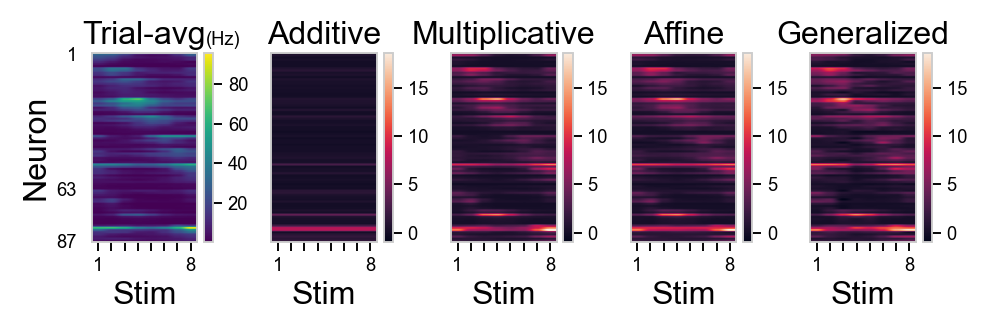

In [44]:
plot_shared_noise_coef(gen_model_V1.d_p, phi_V12, tuning_order_V12)
#plt.savefig('2023_fig/utah_array_joint_stats_model/dataset1_joint_phi_revised.pdf', transparent=True)